In [1]:
%%capture
!pip install tensorflow-cpu==2.16.2

import os
# Suppress oneDNN optimizations and lower TensorFlow logging level
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'


In [2]:
!pip install numpy


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
!pip install matplotlib


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

# Load the data set  
(x_train, _), (x_test, _) = mnist.load_data()

# Normalize the pixel values  
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# Expand dimensions to match the input shape (28, 28, 1)  
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

# Add noise to the data
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

# Clip the values to be within the range [0, 1]
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)


In [5]:
# Define the diffusion model architecture with reduced complexity
input_layer = Input(shape=(28, 28, 1))
x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_layer)  # Reduced filters
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)  # Reduced filters
x = Flatten()(x)
x = Dense(64, activation='relu')(x)  # Reduced size
x = Dense(28*28*32, activation='relu')(x)  # Reduced size
x = Reshape((28, 28, 32))(x)
x = Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(x)  # Reduced filters
x = Conv2DTranspose(16, (3, 3), activation='relu', padding='same')(x)  # Reduced filters
output_layer = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
diffusion_model = Model(input_layer, output_layer)

# Compile the model with mixed precision and a different loss function
diffusion_model.compile(optimizer='adam', loss='mean_squared_error')  # Using MSE for regression tasks

# Summary of the optimized model
diffusion_model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     1,605,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 25088)          │     1,630,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 28, 28, 32)     │         9,248 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 28, 28, 16)     │         4,624 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 1)      │           145 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,255,233 (12.42 MB)

 Trainable params: 3,255,233 (12.42 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# Cache and prefetch the data using TensorFlow data pipelines for faster loading
train_dataset = tf.data.Dataset.from_tensor_slices((x_train_noisy, x_train))
train_dataset = train_dataset.cache().batch(64).prefetch(tf.data.AUTOTUNE)  # Reduced batch size

val_dataset = tf.data.Dataset.from_tensor_slices((x_test_noisy, x_test))
val_dataset = val_dataset.cache().batch(64).prefetch(tf.data.AUTOTUNE)  # Reduced batch size


In [7]:
# Implement early stopping based on validation loss
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Train the model with early stopping and smaller batch size
diffusion_model.fit(
    train_dataset,
    epochs=3,
    shuffle=True,
    validation_data=val_dataset,
    callbacks=[early_stopping]
)

Epoch 1/3
938/938 ━━━━━━━━━━━━━━━━━━━━ 97s 100ms/step - loss: 0.0560 - val_loss: 0.0164
Epoch 2/3
938/938 ━━━━━━━━━━━━━━━━━━━━ 95s 101ms/step - loss: 0.0135 - val_loss: 0.0137
Epoch 3/3
938/938 ━━━━━━━━━━━━━━━━━━━━ 104s 111ms/step - loss: 0.0114 - val_loss: 0.0123


313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step


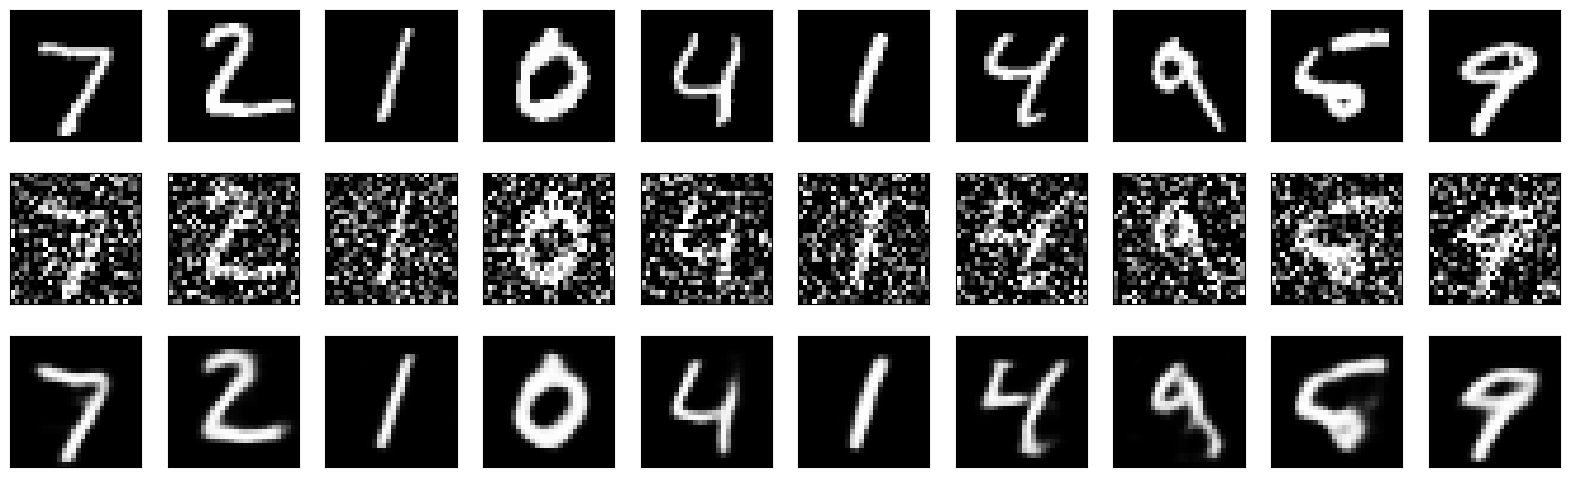

In [8]:
import matplotlib.pyplot as plt

# Predict the denoised images
denoised_images = diffusion_model.predict(x_test_noisy)

# Visualize the results
n = 10  # Number of digits to display
plt.figure(figsize=(20, 6))
for i in range(n):
    # Display original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display noisy
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_test_noisy[i].reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display denoised
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(denoised_images[i].reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [9]:
# Unfreeze the top layers of the model
for layer in diffusion_model.layers[-4:]:
    layer.trainable = True

# Compile the model again
diffusion_model.compile(optimizer='adam', loss='binary_crossentropy')

# Train the model again
diffusion_model.fit(x_train_noisy, x_train,
                    epochs=10,
                    batch_size=64,
                    shuffle=True,
                    validation_data=(x_test_noisy, x_test))


Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 101s 104ms/step - loss: 0.0931 - val_loss: 0.0954
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 89s 94ms/step - loss: 0.0892 - val_loss: 0.0965
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 95s 101ms/step - loss: 0.0861 - val_loss: 0.0970
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 94s 101ms/step - loss: 0.0839 - val_loss: 0.0979
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 133s 141ms/step - loss: 0.0821 - val_loss: 0.0998
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 155s 165ms/step - loss: 0.0806 - val_loss: 0.1006
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 152s 162ms/step - loss: 0.0796 - val_loss: 0.1020
Epoch 8/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 203s 163ms/step - loss: 0.0787 - val_loss: 0.1035
Epoch 9/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 153s 164ms/step - loss: 0.0779 - val_loss: 0.1044
Epoch 10/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 158s 168ms/step - loss: 0.0772 - val_loss: 0.1054


### Improving the performance of the Diffusion Model by finetuning

In [ ]:
# Modify the noise factor to 0.3  
noise_factor = 0.3

# Add noise to the data with the new noise factor  
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

# Clip the values to be within the range [0, 1]  
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

# Retrain the model  
diffusion_model.fit(x_train_noisy, x_train,
                    epochs=50,
                    batch_size=128,
                    shuffle=True,
                    validation_data=(x_test_noisy, x_test))

In [ ]:
# Define the modified diffusion model architecture with additional layers
input_layer = Input(shape=(28, 28, 1))

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x) # Additional layer
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dense(28*28*64, activation='relu')(x)
x = Reshape((28, 28, 64))(x)
x = Conv2DTranspose(128, (3, 3), activation='relu', padding='same')(x) # Additional layer
x = Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x)
x = Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(x)
output_layer = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

diffusion_model = Model(input_layer, output_layer)

# Compile the model  
diffusion_model.compile(optimizer='adam', loss='binary_crossentropy')

# Summary of the model  
diffusion_model.summary()

# Train the model  
diffusion_model.fit(x_train_noisy, x_train,
                    epochs=50,
                    batch_size=128,
                    shuffle=True,
                    validation_data=(x_test_noisy, x_test))